In [105]:
# Imports for Grady's NN Files
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

# My Imports
import csv
import time
import random
from numpy.linalg import norm
from numpy import (array, dot, arccos, clip)
from matplotlib.ticker import FormatStrFormatter

from sklearn import neural_network

__Note:__ We're interested in the algorithms' ability to follow an "optimal" (for now random) path, so we don't need to generate them in _real time_. Which makes it ok to pre-compute the waypoints as opposed to generate them on the fly.

## <center> Path Generation Based on Existing Waypoints </center>

In [106]:
# Getting existing waypoints
fileName = 'Waypoints.txt'
def getWaypoints(fileName):
    f = open(fileName, 'r')
    r = csv.reader(f, delimiter=',')
    xy = [row for row in r]
    x = [float(row[0]) for row in xy]
    y = [float(row[1]) for row in xy]
    f.close()
    return x, y 

# Generating new randomized waypoints from file
def generateWaypoints(fileName, var):
    x, y = getWaypoints(fileName)
    xnew = [(i + random.uniform(-var, var)) for i in x]
    ynew = [(i + random.uniform(-var, var)) for i in y]
    return xnew, ynew

# Generating new randomized waypoints given points
def generateWaypoints2(x, y, xvar, yvar):
    xnew = [(i + random.uniform(-xvar, xvar)) for i in x]
    ynew = [(i + random.uniform(-yvar, yvar)) for i in y]
    return xnew, ynew

In [107]:
waypoints = 'Waypoints.txt'
x_waypoints, y_waypoints = getWaypoints(waypoints)
xrand1, yrand1 = generateWaypoints(waypoints, 0.5)
xrand2, yrand2 = generateWaypoints(waypoints, 1.0)
xrand3, yrand3 = generateWaypoints(waypoints, 1.5)

# Plotting (COMMENTED OUT FOR NOW, tryng simpler paths)
#f1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 5), sharex='col', sharey='row')
#f1.suptitle(r'Original vs. Randomized waypoints (with variance $\sigma = 0.5, 1.0, 1.5$)')
#ax1.plot(x_waypoints, y_waypoints)
#ax2.plot(xrand1, yrand1)
#ax3.plot(xrand2, yrand2)
#ax4.plot(xrand3, yrand3)

# PROBLEM: Doing it this way, you sometimes get waypoints that go backwards if the variance is too high!
# SOLUTION? I could try to find a line perpendicular to the track at each point and generate the randomized point along that...

Text(0.5,0.98,'Waypoints')

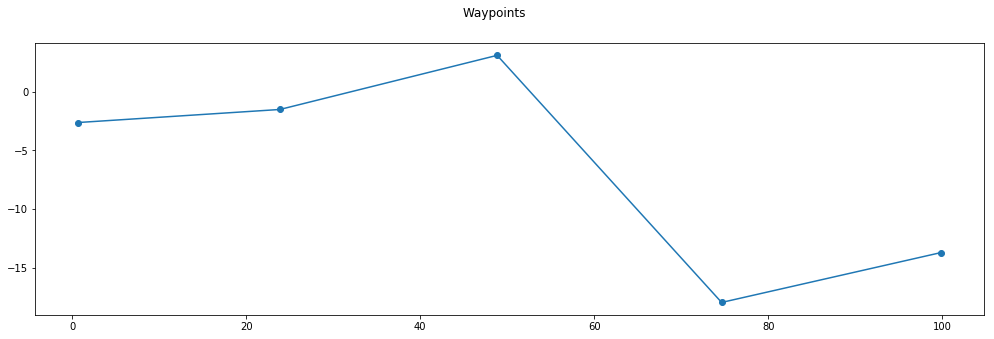

In [306]:
xVariance = 1.5
yVariance = 20
totalDistance = 100
numPoints = 5

x_evenly_spaced = np.linspace(0, totalDistance, numPoints)
y_evenly_spaced = np.linspace(0, 0, numPoints)
x_waypoints, y_waypoints = generateWaypoints2(x_evenly_spaced, y_evenly_spaced, xVariance, yVariance)

f1, ((ax1)) = plt.subplots(1, 1, figsize=(17, 5), sharex='col', sharey='row')
ax1.plot(x_waypoints, y_waypoints, 'o-')
f1.suptitle(r'Waypoints')
#ax1.set_ylim([-5, 5])

In [307]:
ITerm = 0
for i in range(len(x_waypoints) - 1):
    steeringInput, lastSteerError, ITerm = steeringPID(x_waypoints[i], y_waypoints[i], x_waypoints[i + 1], y_waypoints[i + 1], 0, ITerm, 0.1, 0)
    print(round(steeringInput, 10), round(ITerm, 10))

Angle between Heading and Target:  2.741316709547115
0.0047940692 9.569e-06
Angle between Heading and Target:  10.448441832763452
0.0182724431 3.64719e-05
Angle between Heading and Target:  -39.16824102315894
-0.0684981998 -0.000136723
Angle between Heading and Target:  9.551825300392393
0.0167044223 3.33422e-05


In [308]:
steering = np.clip(np.random.randn(250), -1, 1)
throttle = np.clip(np.random.randn(250), -1, 0.75)
steering

array([-1.        ,  1.        , -0.32481385, -0.31026744, -0.64635035,
        0.71161688,  0.16682878,  0.386804  ,  0.27379237,  1.        ,
        0.04954849,  1.        ,  0.88984521, -1.        , -0.59369185,
       -0.04548938,  1.        ,  0.00761148, -0.52425634, -0.98587357,
       -1.        , -0.70315763,  1.        ,  0.2791302 ,  0.38029382,
       -1.        , -0.46709822, -0.87993515, -1.        ,  0.50839996,
        1.        ,  0.55229314,  0.28433714, -1.        ,  0.66299383,
       -0.41673929,  1.        ,  1.        , -0.41877299,  0.95640484,
       -0.06519497,  0.10477963,  0.76174736,  1.        ,  0.68861641,
        0.33991294, -1.        ,  0.08724285, -1.        , -1.        ,
       -0.02624529, -0.66840829, -0.55261619,  0.07244795, -0.09757948,
        0.03376874, -0.7339396 ,  0.88448761,  0.33592707,  0.05841129,
        0.74223098, -1.        , -0.39041846, -0.52739475, -1.        ,
       -0.66325135,  0.20708686,  0.65611096, -0.61526686,  0.65

## <center> Throttle PID Controller (2D Cartesian) </center>
__Note:__ May need to implement smoothing depending on how well this runs

In [25]:
# INPUTS: Current x position, current y position, desired x position, desired y position, whether we just passed a point,
#         time difference since last point
# OUTPUTS: The THROTTLE value to apply, the position error (for future D calculations)
def throttlePID(velocityCurrent, velocityTarget, lastError, ITerm, dtime):
    # 0. Defining random gains
    kp = 0.01
    ki = 0.0002
    kd = 0.005
    ITermMin = -1
    ITermMax = 1
    
    # 1. Find error based on absolute distance between current position and desired position
    velocityError = velocityTarget - velocityCurrent
    
    # 3. Obtain P, I, and D values:
    ## P
    PTerm = kp * velocityError
    
    ## I
    ITerm += ki * velocityError
    if (ITerm > ITermMax):
        ITerm = ITermMax
    elif (ITerm < ITermMin):
        ITerm = ITermMin;
    
    #D
    dError = (velocityError - lastError) / dtime
    DTerm = kd * dError;
    
    sumPID = PTerm + ITerm + DTerm
    return (sumPID, velocityError, ITerm)

In [26]:
throttleInput, lastError, ITerm = throttlePID(0, 3, 0, 0, 0.1)
print(round(throttleInput, 9), round(ITerm, 9))

0.1806 0.0006


Text(0.5,0.98,'Throttle inputs across waypoints')

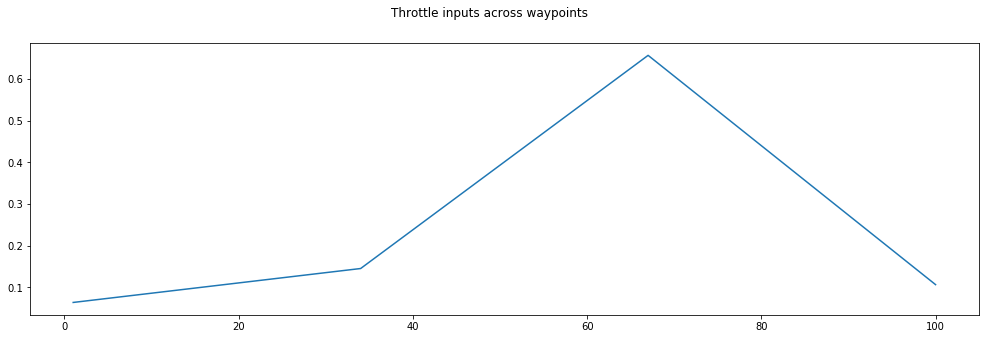

In [35]:
# Testing Throttle PID: Getting PID Values if car had 0 velocity at every waypoint, with lastError = 0 and lastIterm = 0
throttleAtPoints = []
for i, j in zip(range(0, len(x_waypoints) - 1), range(0, len(y_waypoints)-1)):
    distanceBetweenPoints = np.sqrt((x_waypoints[i+1] - x_waypoints[i])**2 + (y_waypoints[i + 1] - y_waypoints[i])**2)
    velocityTarget = distanceBetweenPoints / 10
    #print(velocityTarget)
    sumPID, pastError, ITerm = throttlePID(0, velocityTarget, 0, 0, 0.1)
    throttleAtPoints.append(sumPID)

f2, ((ax2)) = plt.subplots(1, 1, figsize=(17, 5), sharex='col', sharey='row')
ax2.plot(np.linspace(1, 100,len(throttleAtPoints)), throttleAtPoints)
f2.suptitle(r'Throttle inputs across waypoints')
#ax2.set_ylim([0, 1])

## Steering PID Controller

In [178]:
steeringInput, lastSteerError, ITerm = steeringPID(0, 0, -1, 1, 0, 0, 0.1, 0)
print(steeringInput, lastSteerError, ITerm)

-0.7853981633974483
-0.04728096943652639 -0.7853981633974483 -0.00015707963267948965


In [272]:
# INPUTS: Current x position, current y position, desired x position, desired y position, whether we just passed a point,
#         time difference since last point
# OUTPUTS: The STEERING value to apply, the angular error (for future D calculations)
def steeringPID(x_current, y_current, x_target, y_target, lastError, ITerm, dtime, headingCurrent):
    # 0. Defining random gains
    kp = 0.05
    ki = 0.0002
    kd = 0.005
    ITermMin = -2
    ITermMax = 2
    ITerm = 0
    
    # 2. Find error based on angle between current heading direction and direction to target point
    xDiff = x_target - x_current
    yDiff = y_target - y_current
    heading_target = np.arctan(yDiff / (xDiff + 1e-21))     # Addition by tiny constant to avoid division by 0
    print("Angle between Heading and Target: ", heading_target * 180 / math.pi)
    angularError = heading_target - headingCurrent
    
    # 3. Obtain P, I, and D values:
    ## P
    PTerm = kp * angularError
    
    ## I
    ITerm += ki * angularError
    if (ITerm > ITermMax):
        ITerm = ITermMax
    elif (ITerm < ITermMin):
        ITerm = ITermMin;
    
    #D
    dposition = (angularError - lastError) / dtime
    DTerm = kd * dposition;
    
    sumPID = PTerm + ITerm + DTerm
    return (sumPID, angularError, ITerm)

Angle between Heading and Target:  -24.167173325800196
Angle between Heading and Target:  46.02078113252538
Angle between Heading and Target:  -1.141247337056096
Angle between Heading and Target:  -0.016342214264708315


Text(0.5,0.98,'Throttle inputs across waypoints')

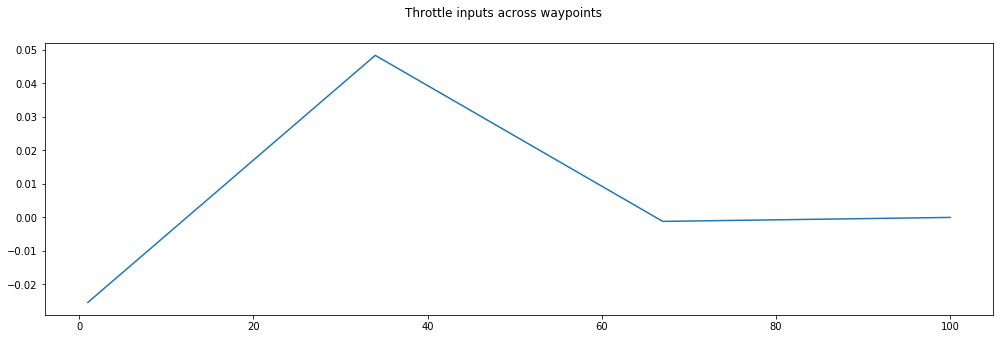

In [71]:
# Testing Steering PID: Same as for throttle PID
steeringAtPoints = []
for i, j in zip(range(0, len(x_waypoints) - 1), range(0, len(y_waypoints)-1)):
    sumPID, pastError, ITerm = steeringPID(x_waypoints[i], y_waypoints[j], x_waypoints[i + 1], y_waypoints[j + 1], 0, 0, 0.1, 0)
    steeringAtPoints.append(sumPID)

f3, ((ax3)) = plt.subplots(1, 1, figsize=(17, 5), sharex='col', sharey='row')
ax3.plot(np.linspace(1, 100,len(steeringAtPoints)), steeringAtPoints)
f3.suptitle(r'Throttle inputs across waypoints')
#ax3.set_ylim([-0.1, 0.1])

## Neural Network State Estimator (Grady's stuff)

In [8]:
# Check if you can input weights for scikit learns MLPRegressor to use the stuff Grady sent.

In [240]:
class AutoRallyNet:

    def __init__(self, save_path, dt = 0.02):
        self.weight_dict = np.load(save_path)
        self.non_linearity = np.tanh
        self.dt = dt
    
    def __call__(self, x, steering, throttle):
        state = np.copy(x) #Don't modify x, return updated state as new variable
        #First compute the state derivative
        fn_input = np.concatenate([state[3:], [steering], [throttle]])
        h1 = np.dot(self.weight_dict["dynamics_W1"], fn_input) + self.weight_dict["dynamics_b1"]
        h1 = np.tanh(h1)
        h2 = np.dot(self.weight_dict["dynamics_W2"], h1) + self.weight_dict["dynamics_b2"]
        h2 = np.tanh(h2)
        state_der = np.dot(self.weight_dict["dynamics_W3"], h2) + self.weight_dict["dynamics_b3"]
        #Now compute the actual state update
        state[0] += (np.cos(state[2])*state[4] - np.sin(state[2])*state[5])*self.dt
        state[1] += (np.sin(state[2])*state[4] + np.cos(state[2])*state[5])*self.dt
        state[2] += -state[6]*self.dt #Sixth state is NEGATIVE of yaw derivative
        state[3] += state_der[0]*self.dt
        state[4] += state_der[1]*self.dt
        state[5] += state_der[2]*self.dt
        state[6] += state_der[3]*self.dt
        return state

In [110]:
def animate(npy_array, name):
    save_as = name + ".mp4"
    Xs = npy_array[:, 0]
    Ys = npy_array[:, 1]
    Yaw = npy_array[: ,2]
    Vx = npy_array[:, 4]
    Vy = npy_array[:, 4]*np.tan(npy_array[:, 3])
    T = range(Xs.size)
    fig = plt.figure()
    ax = plt.axes(xlim=(0,20), ylim = (-10,10))
    Xs = np.array(Xs)
    Ys = np.array(Ys)
    lines = []
    line, = ax.plot([],[])
    circs = []
    circs.append(Rectangle((Xs[0] - .30, Ys[0] - .13), .6, .26, color = 'r'))
    def init():
        line.set_data([], [])
        for c in circs:
            ax.add_patch(c)
        return circs,
    def animate(k):
        for c in circs:
            heading = Yaw[k]/np.pi * 180.0
            t = mpl.transforms.Affine2D().rotate_deg_around(Xs[k], Ys[k], heading) + ax.transData
            c.set_transform(t)
            c.set_xy((Xs[k] - .3, Ys[k] - .13))
        x = np.copy(Xs[:k])
        y = np.copy(Ys[:k])
        sys.stdout.write("Making Animation: %d/%d \r" % (k, len(Xs)))
        sys.stdout.flush()
        line.set_data(x,y)
        line.set_alpha(.1)
        return circs,
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames = len(Xs), interval=20,blit=True)
    anim.save(save_as, fps=50, writer='avconv', bitrate = 2500)

In [32]:
if __name__ == "__main__":
    steering = np.clip(np.random.randn(250), -1, 1)        # Generates values from the normal distribution clamped between [-1 1]
    throttle = np.clip(np.random.randn(250), -1, 0.75)
    x = np.array([0, 0, 0, 0, 5.0, 0.5, 0])
    state_history = []

    f = AutoRallyNet("alpha_nnet.npz")

    for i in range(250):
        state_history.append(x)
        x = f(x, steering[i], throttle[i])

    #animate(np.asarray(state_history), "random_controls")

## <center> MAIN CONTROLLER <center>

In [273]:
def runPID():
    TIME_RUNNING_SIMLUATION = 1
    
    # Definiing Initial States and Targets
    targetIndex = 1
    x_start, y_start = x_waypoints[0], y_waypoints[0]
    x_target, y_target = x_waypoints[targetIndex], y_waypoints[targetIndex]      # Starting target positions
    x = np.array([x_start, y_start, 0, 0, 5.0, 0.5, 0])                          # Initial state
    x_last = x                                                                   # Last state, initialized at x to avoid index error
    
    # Recording important vlaues
    state_history = []   
    throttle_history = []
    steering_history = []
    
    # PID values:
    lastThrottleError = 0
    lastSteeringError = 0
    velocityCurrent = 0
    velocityTarget = 0
    lastThrottleITerm = 0
    lastSteeringITerm = 0;
    
    # Necessary/Useful Constants
    changingPoint = True
    proxThreshold = 0.25                                                   # Proximity to a point within which we have "reached it"
    timeBetweenTargets = 10
    dtime = 0.02
    f = AutoRallyNet("alpha_nnet.npz")
    
    # Start timer and loop
    keepGoing = True
    startTime = time.time()
    while(keepGoing):        
        # 1. Our current and target x and y are defined, if we're close enough to the desired, update target to next waypoint
        xCurr, yCurr = x[0], x[1]
        xLast, yLast = x_last[0], x_last[1]
        distanceToTarget = np.sqrt((x_target - xCurr)**2 + (y_target - yCurr)**2)
        if (distanceToTarget < proxThreshold):
            x_start, y_start = x_target, y_target
            targetIndex += 1
            x_target, y_target = x_waypoints[targetIndex], y_waypoints[targetIndex]
            changingPoint = True
        else:
            changingPoint = False
        
        # 2.a) Compute throttle PID
        distanceBetweenPoints = np.sqrt((x_target - x_start)**2 + (y_target - y_start)**2)
        velocityTarget = distanceBetweenPoints / timeBetweenTargets   # target velocity = distance / time in which you want to cover it
        velocityCurrent = np.sqrt((xCurr - xLast)**2 + (yCurr - yLast)**2) / dtime    # current velocity is distance traveled since last time / time elapsed
        throttleInput, lastThrottleError, lastThrottleITerm = throttlePID(velocityCurrent, velocityTarget, changingPoint, lastThrottleError, dtime)
        
        # 2.b) Compute steering PID
        steeringInput, lastSteeringError, lastSteeringITerm = steeringPID(xCurr, yCurr, x_target, y_target, lastSteeringError, lastSteeringITerm, dtime, x[3])

        
        # 3. Apply that PID and use the NN to estimate new position. PROBLEM: Do it time or space based? SOLUTION? Try time interval of 0.01s first (edge case is if we're not moving, handle that too)
        state_history.append(x)
        throttle_history.append(throttleInput)
        steering_history.append(steeringInput)
        x_last = x
        x = f(x, steeringInput, throttleInput)
        print(steeringInput, throttleInput)
        
        # 4. Stop running after however long/many laps you want
        currTime = time.time()
        if (currTime - startTime >= TIME_RUNNING_SIMLUATION):
            keepGoing = False
        #time.sleep(dtime)
    
    return (state_history, throttle_history)

In [274]:
state_history, throttle_history = runPID()

Angle between Heading and Target:  -30.136884868706943
-0.15790155774946923 0.22573149852750785
Angle between Heading and Target:  -30.529269502199323
-0.02874937493295038 -0.21422657985907645
Angle between Heading and Target:  -30.923433547322006
-0.029254478554052724 -2.078439020194459
Angle between Heading and Target:  -31.320072587356727
-0.028892139353661597 -2.0706227232954513
Angle between Heading and Target:  -31.715671458362717
-0.0291846175970443 -2.0353380939043575
Angle between Heading and Target:  -32.109524459063806
-0.02947688156899475 -2.0006821457726365
Angle between Heading and Target:  -32.50094949731612
-0.02976755100542588 -1.9667080599186155
Angle between Heading and Target:  -32.889303289628835
-0.03005649972015353 -1.9333928811350953
Angle between Heading and Target:  -33.27397716904248
-0.030343629686971588 -1.9007148017166757
Angle between Heading and Target:  -33.65439390712313
-0.030628866497371333 -1.868653657160364
Angle between Heading and Target:  -34.03

-0.04484544846631312 0.09347585174980791
Angle between Heading and Target:  -50.19509026649825
-0.04495091838272397 0.09345913145394148
Angle between Heading and Target:  -50.31498497636434
-0.04505671348465271 0.09344256797272701
Angle between Heading and Target:  -50.43525299952923
-0.045162835533543236 0.09342615284342082
Angle between Heading and Target:  -50.55589596961619
-0.045269286255446226 0.09340987811411156
Angle between Heading and Target:  -50.6769154984676
-0.04537606734226853 0.09339373626300647
Angle between Heading and Target:  -50.79831317667852
-0.045483180452951515 0.09337772014099753
Angle between Heading and Target:  -50.92009057410717
-0.045590627214585476 0.09336182293376136
Angle between Heading and Target:  -51.04224924036044
-0.045698409223465214 0.09334603813867777
Angle between Heading and Target:  -51.1647907052533
-0.04580652804608961 0.09333035955090212
Angle between Heading and Target:  -51.28771647924164
-0.04591498522010783 0.09331478125420946
Angle 

-0.059525187723402144 0.0917826150301171
Angle between Heading and Target:  -66.87701037867735
-0.05967423789581685 0.0917680108167743
Angle between Heading and Target:  -67.04636966979409
-0.05982366213061095 0.09175340146920515
Angle between Heading and Target:  -67.21615689768144
-0.0599734592238464 0.09173878714764731
Angle between Heading and Target:  -67.38637082510586
-0.06012362793280941 0.09172416801599227
Angle between Heading and Target:  -67.55701017199222
-0.06027416697573449 0.09170954424175141
Angle between Heading and Target:  -67.7280736150894
-0.06042507503153345 0.09169491599602117
Angle between Heading and Target:  -67.89955978764031
-0.06057635073952961 0.09168028345342348
Angle between Heading and Target:  -68.07146727905725
-0.06072799269919712 0.09166564679201171
Angle between Heading and Target:  -68.24379463460228
-0.06087999946990585 0.09165100619332961
Angle between Heading and Target:  -68.41654035507307
-0.061032369570670396 0.09163636184228245
Angle betwe

0.07799223493512242 0.0899975668101276
Angle between Heading and Target:  89.4866221998493
0.07740469051855281 0.0914437878561094
Angle between Heading and Target:  89.29102262782511
0.07723347781083678 0.09781624321257096
Angle between Heading and Target:  89.09614370416882
0.07706095983299047 0.10147720643164279
Angle between Heading and Target:  88.90164495352639
0.0768889422283324 0.10445834753605779
Angle between Heading and Target:  88.70731382189351
0.07671688795799028 0.10594369761856609
Angle between Heading and Target:  88.51297098993216
0.07654505400920758 0.106453386542656
Angle between Heading and Target:  88.31851603467133
0.07637343738069721 0.10618477359883055
Angle between Heading and Target:  88.12390196673364
0.07620212621091745 0.10549268741742454
Angle between Heading and Target:  87.92912492877481
0.07603115893520314 0.10462449518056259
Angle between Heading and Target:  87.73420472183155
0.07586054879928851 0.10376962403353401
Angle between Heading and Target:  8

0.05498720882915451 0.09288938247984176
Angle between Heading and Target:  63.1453758477278
0.05482130326757607 0.09285995537930708
Angle between Heading and Target:  62.95174208562297
0.05465542642651383 0.09283068030508104
Angle between Heading and Target:  62.75815650762819
0.05448957890421033 0.09280155602803729
Angle between Heading and Target:  62.564619766225945
0.054323761301948444 0.09277258135446936
Angle between Heading and Target:  62.371132516133905
0.054157974223985814 0.09274375512435523
Angle between Heading and Target:  62.177695414278276
0.05399221827748925 0.09271507620970595
Angle between Heading and Target:  61.984309119767026
0.053826494072472135 0.09268654351264008
Angle between Heading and Target:  61.790974293863336
0.05366080222173344 0.09265815596397421
Angle between Heading and Target:  61.59769159995868
0.05349514334079754 0.09262991252158621
Angle between Heading and Target:  61.4044617035462
0.0533295180478566 0.09260181216887593
Angle between Heading and

0.039443939882138165 0.090657628414626
Angle between Heading and Target:  45.061107701191425
0.03928369731751769 0.09063922474208987
Angle between Heading and Target:  44.87518305829659
0.03912354732204166 0.090620909426229
Angle between Heading and Target:  44.68937451220267
0.038963490582917815 0.09060268197762568
Angle between Heading and Target:  44.503682792182495
0.038803527786484916 0.0905845419087413
Angle between Heading and Target:  44.318108626682324
0.038643659618178366 0.09056648873393476
Angle between Heading and Target:  44.132652743286215
0.0384838867624959 0.09054852196950308
Angle between Heading and Target:  43.947315868680455
0.03832420990296297 0.09053064113361825
Angle between Heading and Target:  43.76209872861793
0.038164629722098914 0.0905128457463974
Angle between Heading and Target:  43.57700204788279
0.03800514690138266 0.09049513532975126
Angle between Heading and Target:  43.392026550255025
0.037845762121219324 0.09047750940763233
Angle between Heading and

0.020045995331826716 0.08888439131392788
Angle between Heading and Target:  22.603728174711136
0.019902405901829713 0.08887394694100736
Angle between Heading and Target:  22.43777314936858
0.01975897978704082 0.08886354439340635
Angle between Heading and Target:  22.272009885316965
0.01961571735495782 0.08885318342334503
Angle between Heading and Target:  22.106438777961884
0.01947261896958174 0.08884286378451613
Angle between Heading and Target:  21.941060218931828
0.019329684991413167 0.0888325852323387
Angle between Heading and Target:  21.775874596072967
0.019186915777449434 0.0888223475237787
Angle between Heading and Target:  21.61088229344423
0.019044311681181723 0.08881215041740086
Angle between Heading and Target:  21.44608369131265
0.018901873052592583 0.08880199367334635
Angle between Heading and Target:  21.281479166149023
0.01875960023815369 0.08879187705328573
Angle between Heading and Target:  21.117069090623858
0.018617493580823926 0.08878180032053072
Angle between Head

0.004424158094160012 0.08789233812392848
Angle between Heading and Target:  4.563109889986534
0.0043012755595917985 0.08788546485691202
Angle between Heading and Target:  4.421297445024711
0.004178576431600074 0.0878786132856101
Angle between Heading and Target:  4.2796979475618375
0.004056060702156968 0.08787178329818357
Angle between Heading and Target:  4.138311379655626
0.0039337283606777915 0.08786497478352832
Angle between Heading and Target:  3.997137720503779
0.0038115793940357552 0.08785818763139806
Angle between Heading and Target:  3.8561769464600677
0.00368961378657687 0.0878514217322673
Angle between Heading and Target:  3.7154290310504625
0.0035678315201349373 0.08784467697728464
Angle between Heading and Target:  3.5748939449893053
0.003446232574046553 0.0878379532585277
Angle between Heading and Target:  3.4345716561955206
0.0033248169251657907 0.0878312504685644
Angle between Heading and Target:  3.2944621298089034
0.0032035845478797583 0.08782456850084316
Angle betwee

-0.006861310314759368 0.0873021011618403
Angle between Heading and Target:  -8.45571270009907
-0.006966418680557261 0.08729693431819582
Angle between Heading and Target:  -8.576916695791047
-0.007071354472084952 0.0872917810476654
Angle between Heading and Target:  -8.697920799013511
-0.007176117877889406 0.08728664129188615
Angle between Heading and Target:  -8.818725230915604
-0.007280709087631744 0.08728151499286382
Angle between Heading and Target:  -8.939330213907958
-0.007385128292074274 0.08727640209299213
Angle between Heading and Target:  -9.059735971648376
-0.007489375683067963 0.08727130253493852
Angle between Heading and Target:  -9.179942729027609
-0.007593451453539933 0.08726621626187613
Angle between Heading and Target:  -9.299950712155152
-0.007697355797480908 0.0872611432171561
Angle between Heading and Target:  -9.419760148345121
-0.0078010889099325905 0.087256083344605
Angle between Heading and Target:  -9.539371266102215
-0.007904650986975521 0.0872510365883138
Angl

-0.016284217324346997 0.08685660574009402
Angle between Heading and Target:  -19.31792126350351
-0.016373588072035088 0.08685252885931627
Angle between Heading and Target:  -19.42090606810571
-0.016462808062969705 0.08684846123671698
Angle between Heading and Target:  -19.523716427999908
-0.016551877543775965 0.08684440283885536
Angle between Heading and Target:  -19.626352630054193
-0.01664079676125069 0.08684035363273102
Angle between Heading and Target:  -19.728814961327696
-0.016729565962355843 0.0868363135853085
Angle between Heading and Target:  -19.83110370906286
-0.016818185394211392 0.08683228266382961
Angle between Heading and Target:  -19.933219160677833
-0.01690665530408924 0.08682826083569448
Angle between Heading and Target:  -20.035161603758887
-0.016994975939406225 0.08682424806842866
Angle between Heading and Target:  -20.136931326052892
-0.017083147547717815 0.08682024432969099
Angle between Heading and Target:  -20.238528615459902
-0.01717117037671155 0.0868162495873

-0.02629333116032252 0.08641276348549351
Angle between Heading and Target:  -30.84700797275516
-0.026365890482816894 0.08640962575335562
Angle between Heading and Target:  -30.930549376529598
-0.02643832932285859 0.0864064941923431
Angle between Heading and Target:  -31.013951509989226
-0.02651064791209262 0.08640336878408852
Angle between Heading and Target:  -31.097214642068504
-0.0265828464818502 0.0864002495103086
Angle between Heading and Target:  -31.180339041336026
-0.026654925263148253 0.08639713635286986
Angle between Heading and Target:  -31.263324975992518
-0.0267268844866868 0.0863940292936876
Angle between Heading and Target:  -31.34617271386895
-0.026798724382847867 0.08639092831465511
Angle between Heading and Target:  -31.42888252242456
-0.026870445181693344 0.08638783339784303
Angle between Heading and Target:  -31.511454668745092
-0.026942047112964034 0.08638474452534468
Angle between Heading and Target:  -31.593889419540872
-0.02701353040607744 0.08638166167947595
An

-0.03286550125985417 0.086132066524364
Angle between Heading and Target:  -38.41159068644309
-0.03292730206041594 0.08612945701284984
Angle between Heading and Target:  -38.4827008793091
-0.0329890034115908 0.08612685219303354
Angle between Heading and Target:  -38.55369621161354
-0.033050605509445934 0.08612425205257179
Angle between Heading and Target:  -38.624576910811
-0.03311210854966205 0.08612165657916472
Angle between Heading and Target:  -38.69534320390581
-0.033173512727533 0.08611906576067058
Angle between Heading and Target:  -38.765995317452145
-0.03323481823796654 0.08611647958491718
Angle between Heading and Target:  -38.83653347755392
-0.03329602527548337 0.08611389803962724
Angle between Heading and Target:  -38.906957909864786
-0.03335713403421774 0.08611132111283451
Angle between Heading and Target:  -38.97726883958816
-0.0334181447079173 0.08610874879241114
Angle between Heading and Target:  -39.04746649147723
-0.033479057489943016 0.08610618106641835
Angle between 

-0.038688950206115506 0.08588812740232207
Angle between Heading and Target:  -45.11033534549712
-0.038741551308800894 0.08588594007352748
Angle between Heading and Target:  -45.170824763792865
-0.038794070998983333 0.08588375638461487
Angle between Heading and Target:  -45.2312202377015
-0.03884650943446246 0.08588157632694421
Angle between Heading and Target:  -45.291521950132065
-0.03889886677268422 0.08587939989201909
Angle between Heading and Target:  -45.35173008358223
-0.0389511431707415 0.08587722707138189
Angle between Heading and Target:  -45.4118448201389
-0.03900333878537506 0.08587505785650384
Angle between Heading and Target:  -45.47186634147892
-0.039055453772973474 0.08587289223896873
Angle between Heading and Target:  -45.531794828869735
-0.039107488289574284 0.08587073021036051
Angle between Heading and Target:  -45.59163046316999
-0.0391594424908639 0.08586857176222934
Angle between Heading and Target:  -45.65137342483025
-0.03921131653217883 0.08586641688635548
Angle

-0.043434279418758714 0.08569173343081075
Angle between Heading and Target:  -50.56599092252935
-0.04347966815140091 0.08568986314778651
Angle between Heading and Target:  -50.618161109576825
-0.04352498922047024 0.08568799579159996
Angle between Heading and Target:  -50.670253282493306
-0.04357024275231257 0.08568613135598822
Angle between Heading and Target:  -50.72226758760434
-0.04361542887298187 0.08568426983474373
Angle between Heading and Target:  -50.77420417089495
-0.043660547708239454 0.0856824112215386
Angle between Heading and Target:  -50.826063178010315
-0.043705599383554915 0.0856805555101969
Angle between Heading and Target:  -50.87784475425673
-0.04375058402410712 0.08567870269458855
Angle between Heading and Target:  -50.929549044602155
-0.04379550175478467 0.08567685276841654
Angle between Heading and Target:  -50.98117619367712
-0.04384035270018646 0.08567500572564832
Angle between Heading and Target:  -51.03272634577544
-0.04388513698462253 0.08567316156007096
Angl

-0.047460684368099304 0.08552631412153995
Angle between Heading and Target:  -55.1930387716547
-0.04750017070628533 0.08552469633033159
Angle between Heading and Target:  -55.23840621511538
-0.04753960016472064 0.08552308094674169
Angle between Heading and Target:  -55.283708128337636
-0.04757897284476434 0.08552146796594964
Angle between Heading and Target:  -55.328944628605655
-0.04761828884754132 0.08551985738322972
Angle between Heading and Target:  -55.37411583293225
-0.047657548273943556 0.08551824919389522
Angle between Heading and Target:  -55.419221858059394
-0.04769675122463049 0.08551664339301313
Angle between Heading and Target:  -55.46426282045906
-0.047735897800029604 0.08551503997617184
Angle between Heading and Target:  -55.50923883633381
-0.047774988100337326 0.08551343893847818
Angle between Heading and Target:  -55.55415002161744
-0.047814022225518865 0.0855118402753981
Angle between Heading and Target:  -55.598996491975726
-0.04785300027530981 0.08551024398245974
An

-0.05185290035655128 0.08534677952223531
Angle between Heading and Target:  -60.23834965789519
-0.05188617755858502 0.0853454221019625
Angle between Heading and Target:  -60.276566776955654
-0.05191940860753218 0.08534406660044065
Angle between Heading and Target:  -60.3147307713158
-0.051952593580393405 0.08534271301396121
Angle between Heading and Target:  -60.35284172997632
-0.05198573255399776 0.08534136133919504
Angle between Heading and Target:  -60.3908997417392
-0.052018825605003864 0.08534001157302265
Angle between Heading and Target:  -60.42890489520827
-0.052051872809900486 0.0853386637117052
Angle between Heading and Target:  -60.46685727878964
-0.05208487424500528 0.08533731775203389
Angle between Heading and Target:  -60.50475698069231
-0.05211782998646758 0.08533597369062854
Angle between Heading and Target:  -60.542604088928584
-0.05215074011026711 0.08533463152410152
Angle between Heading and Target:  -60.580398691314706
-0.05218360469221547 0.08533329124895529
Angle b

-0.05625907069231239 0.0851673112674266
Angle between Heading and Target:  -65.2975868358091
-0.05628634514324222 0.08516620171458332
Angle between Heading and Target:  -65.32889764570308
-0.056313583077909825 0.08516509366054241
Angle between Heading and Target:  -65.36016646285348
-0.056340784552500245 0.08516398710258417
Angle between Heading and Target:  -65.39139335211951
-0.056367949623081406 0.08516288203877795
Angle between Heading and Target:  -65.42257837822461
-0.05639507834560476 0.08516177846639658
Angle between Heading and Target:  -65.45372160575702
-0.05642217077590522 0.08516067638306708
Angle between Heading and Target:  -65.48482309916987
-0.056449226969701075 0.0851595757865347
Angle between Heading and Target:  -65.51588292278171
-0.05647624698259544 0.08515847667440288
Angle between Heading and Target:  -65.54690114077675
-0.05650323087007531 0.08515737904436473
Angle between Heading and Target:  -65.57787781720536
-0.05653017868751286 0.08515628289386559
Angle be

-0.059540372693112006 0.08503390195619534
Angle between Heading and Target:  -69.06399129126235
-0.05956330235949024 0.08503297012214497
Angle between Heading and Target:  -69.09030747835924
-0.05958620197413136 0.08503203951349082
Angle between Heading and Target:  -69.11658913150455
-0.059609071580166886 0.08503111012870938
Angle between Heading and Target:  -69.14283630043714
-0.05963191122064519 0.08503018196567742
Angle between Heading and Target:  -69.16904903479853
-0.059654720938529825 0.085029255022844
Angle between Heading and Target:  -69.1952273841333
-0.059677500776701635 0.08502832929819301
Angle between Heading and Target:  -69.22137139788924
-0.05970025077795748 0.08502740479029385
Angle between Heading and Target:  -69.24748112541768
-0.05972297098501171 0.08502648149698976
Angle between Heading and Target:  -69.2735566159736
-0.05974566144049485 0.08502555941673975
Angle between Heading and Target:  -69.299597918716
-0.05976832218695536 0.08502463854779929
Angle betwe

-0.06234177361687058 0.08492007817118201
Angle between Heading and Target:  -72.2788322876699
-0.06236105523449389 0.08491929482436283
Angle between Heading and Target:  -72.30095760111467
-0.0623803118726328 0.08491851249265134
Angle between Heading and Target:  -72.32305422711603
-0.06239954356487039 0.08491773117451322
Angle between Heading and Target:  -72.3451222043643
-0.06241875034472906 0.08491695086892567
Angle between Heading and Target:  -72.36716157147947
-0.062437932245670416 0.08491617157421638
Angle between Heading and Target:  -72.38917236701128
-0.062457089301095524 0.0849153932890407
Angle between Heading and Target:  -72.41115462943947
-0.062476221544344845 0.08491461601200655
Angle between Heading and Target:  -72.43310839717385
-0.062495329008698676 0.08491383974178149
Angle between Heading and Target:  -72.45503370855455
-0.06251441172737728 0.08491306447710224
Angle between Heading and Target:  -72.47693060185216
-0.06253346973354078 0.08491229021655405
Angle bet

-0.06461763856734665 0.08482761455641577
Angle between Heading and Target:  -74.89019968506771
-0.06463397643020898 0.08482695072796353
Angle between Heading and Target:  -74.90894511580895
-0.06465029316258636 0.08482628775679847
Angle between Heading and Target:  -74.92766629166077
-0.06466658879131341 0.08482562564187512
Angle between Heading and Target:  -74.94636324351347
-0.06468286334317992 0.08482496438197434
Angle between Heading and Target:  -74.96503600220508
-0.06469911684493028 0.08482430397602019
Angle between Heading and Target:  -74.98368459852114
-0.06471534932326323 0.08482364442309707
Angle between Heading and Target:  -75.00230906319517
-0.06473156080483347 0.08482298572203745
Angle between Heading and Target:  -75.02090942690859
-0.06474775131624982 0.0848223278716896
Angle between Heading and Target:  -75.03948572029084
-0.06476392088407658 0.08482167087102851
Angle between Heading and Target:  -75.05803797391961
-0.06478006953483353 0.08482101471886783
Angle betw

-0.06609340780902823 0.08476764584930284
Angle between Heading and Target:  -76.58340513690783
-0.06610783335110836 0.08476705958473557
Angle between Heading and Target:  -76.59995584102224
-0.06612224014559016 0.08476647408041048
Angle between Heading and Target:  -76.61648503249019
-0.06613662821537895 0.0847658893353656
Angle between Heading and Target:  -76.63299273766306
-0.06615099758334231 0.08476530534865925
Angle between Heading and Target:  -76.64947898284983
-0.06616534827231149 0.08476472211941813
Angle between Heading and Target:  -76.66594379431709
-0.06617968030508142 0.08476413964670278
Angle between Heading and Target:  -76.68238719828908
-0.06619399370441004 0.08476355792972379
Angle between Heading and Target:  -76.69880922094792
-0.06620828849301927 0.08476297696742682
Angle between Heading and Target:  -76.7152098884336
-0.06622256469359412 0.08476239675883104
Angle between Heading and Target:  -76.73158922684406
-0.06623682232878352 0.08476181730304913
Angle betwe

-0.06765967305457704 0.08470398056097955
Angle between Heading and Target:  -78.38040714234351
-0.06767205153911593 0.08470347730220745
Angle between Heading and Target:  -78.39460927552703
-0.06768441372526227 0.08470297470419288
Angle between Heading and Target:  -78.40879271295915
-0.06769675963209931 0.08470247276632352
Angle between Heading and Target:  -78.42295747658194
-0.06770908927868262 0.08470197148773802
Angle between Heading and Target:  -78.43710358830411
-0.06772140268403852 0.08470147086774178
Angle between Heading and Target:  -78.4512310700012
-0.06773369986716443 0.08470097090544024
Angle between Heading and Target:  -78.46533994351556
-0.06774598084702924 0.0847004716003946
Angle between Heading and Target:  -78.47943023065652
-0.06775824564257368 0.08469997295151258
Angle between Heading and Target:  -78.49350195320032
-0.06777049427270908 0.08469947495803654
Angle between Heading and Target:  -78.50755513289033
-0.0677827267563187 0.08469897761934626
Angle betwee

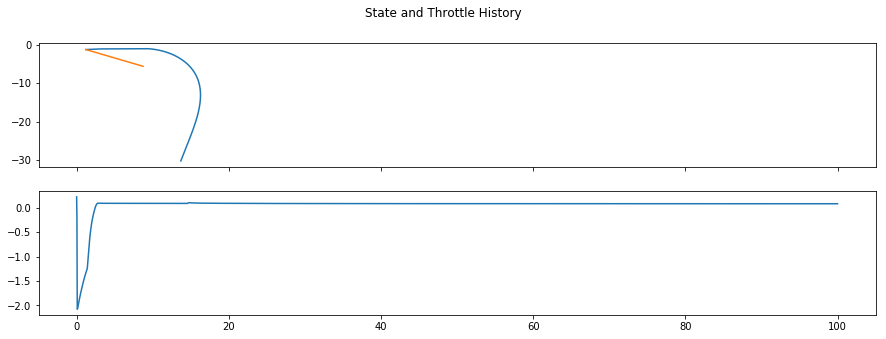

In [275]:
x_states = [row[0] for row in state_history]
y_states = [row[1] for row in state_history]
x_time = np.linspace(0, 100, len(throttle_history))

f1, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(15, 5), sharex='col', sharey='row')
f1.suptitle(r'State and Throttle History')
ax1.plot(x_states, y_states, x_waypoints, y_waypoints)
ax2.plot(x_time, throttle_history)